# P0: Intro

<div style="text-align:justify">Hopefully, the course has been insightful for you till now. This notebook serves as a template for the project which involves training a sentiment analyzer neural network using the comments of a Persian website and fine-tuning it using the comments of another.<br><br>
The first website is Snappfood which is used by the people in Iran to order different kinds of food. The latter is Digikala, an online store for Iranians where people buy many things including smartphones, groceries, cars, and whatever you consider legal. Both websites provide users with ways to express their opinions about the products.<br><br>
A domain shift may be revealed to some degree when switching from Snappfood comments to the ones extracted from Digikala. This will be one of the challenges you will be faced with. So, beware of it!</div>

In [5]:
from hazm import *
from parsivar import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, MaxPooling1D, Flatten, Conv1D
from sklearn.metrics import classification_report, accuracy_score
import os
import json
from tensorflow import keras
import re
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# P1: Exploring the Datasets

Both of the datasets are added to the notebook. In this part, we want to explore their contents. 

Load both of the datasets 

In [7]:
digikala = pd.read_csv(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Data\Digikala\data.csv")
snappFood =  pd.read_csv(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Data\Snapp Food\Snappfood - Sentiment Analysis.csv", sep='\t+')

Count the number of comments each dataset contains 

In [8]:
digikala_comments_count = digikala.shape[0]
snappfood_comments_count = snappFood.shape[0]

print(f"Digikala dataset contains {digikala_comments_count} comments.")
print(f"SnappFood dataset contains {snappfood_comments_count} comments.")

Digikala dataset contains 3261 comments.
SnappFood dataset contains 70000 comments.


Represent the distribution of comments in the Snappfood dataset in terms of being negative or positive 

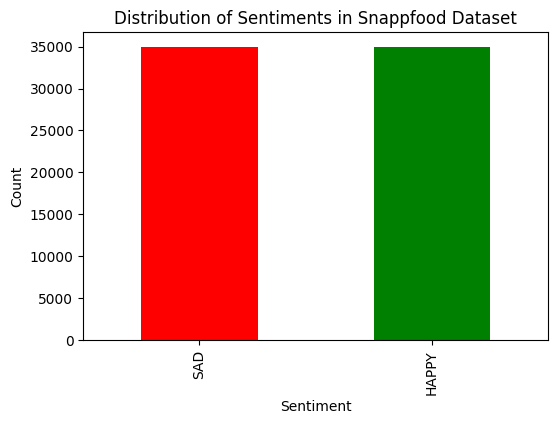

In [9]:
sentiment_distribution = snappFood['label'].value_counts()
plt.figure(figsize=(6, 4))
sentiment_distribution.plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Sentiments in Snappfood Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law. <br>
Note: Don't panic! The Zipf's law can be found here: https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html and can be easily understood.

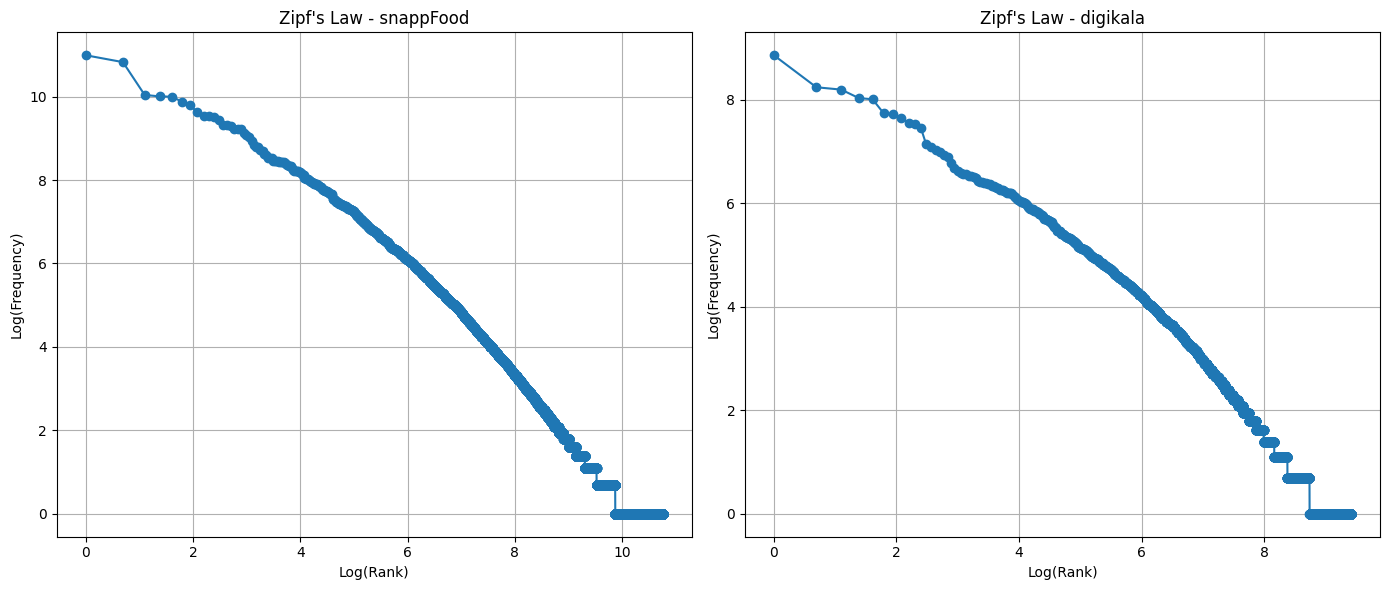

In [10]:
def plot_zipf_law(text_data):
    all_words = [word for text in text_data for word in str(text).split()]
    word_counts = Counter(all_words)
    word_ranks = np.arange(1, len(word_counts) + 1)
    word_frequencies = [count for _, count in word_counts.most_common()]

    plt.plot(np.log(word_ranks), np.log(word_frequencies), marker='o')


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_zipf_law(snappFood['comment'])
plt.title("Zipf's Law - snappFood")
plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.grid(True)

plt.subplot(1, 2, 2)
plot_zipf_law(digikala['Text'])
plt.title("Zipf's Law - digikala")
plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.grid(True)

plt.tight_layout()
plt.show()

Add a new column to the Digikala dataset indicating whether the comment was positive, negative, or neutral. This will be needed later for classification. <br>
Note: This can be done in many ways. You should the appropriate method. 

In [11]:
def determine_label(score):
    if score >= 80:
        return 'positive'
    elif 55 < score < 80:
        return 'neutral'
    else:
        return 'negative'

digikala['sentiment'] = digikala['Score'].apply(determine_label)
digikala.head()

,Text,Score,Suggestion,sentiment
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1,positive
1,خرید این محصول رو توصیه میکنم,84,1,positive
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1,neutral
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1,positive
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1,positive


Split each dataset into training, testing, and validation sets.

In [12]:
# Splitting Digikala dataset
digikala_encoded = pd.get_dummies(digikala, columns=['sentiment'], dtype=int)
y_digikala = np.array([digikala_encoded['sentiment_positive'].to_list(), digikala_encoded['sentiment_neutral'].to_list(), digikala_encoded['sentiment_negative'].to_list()]).T

X_train_digikala, X_temp_digikala, y_train_digikala, y_temp_digikala = train_test_split(digikala['Text'], y_digikala, test_size=0.2, random_state=42)
X_val_digikala, X_test_digikala, y_val_digikala, y_test_digikala = train_test_split(X_temp_digikala, y_temp_digikala, test_size=0.5, random_state=42)

# Splitting Snappfood dataset
X_train_snappfood, X_temp_snappfood, y_train_snappfood, y_temp_snappfood = train_test_split(snappFood['comment'], snappFood['label_id'], test_size=0.2, random_state=42)
X_val_snappfood, X_test_snappfood, y_val_snappfood, y_test_snappfood = train_test_split(X_temp_snappfood, y_temp_snappfood, test_size=0.5, random_state=42)

# P2: Preprocessing and Feature Extraction 

The goal of this part is to make the Snappfood dataset ready for the neural network to be trained with.<br>
Note: You can use many libraries including `NLTK`, `Spacy`, `Hazm`, `Parsivar`, `Stanza` etc.

Remove the unnecessary characters of the dataset. <br>


In [13]:
X_train_snappfood = X_train_snappfood.apply(lambda x: re.sub(r'[\da-zA-Z\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', x))
X_val_snappfood = X_val_snappfood.apply(lambda x: re.sub(r'[\da-zA-Z\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', x))
X_test_snappfood = X_test_snappfood.apply(lambda x: re.sub(r'[\da-zA-Z\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', x))

Normalize the dataset. <br>
Note: Check the result. For instance, if you do this correctly, you'll have a dataset containing just 1 type of space. 

In [14]:
normalizer = Normalizer()

X_train_snappfood = X_train_snappfood.apply(normalizer.normalize)
X_val_snappfood = X_val_snappfood.apply(normalizer.normalize)
X_test_snappfood = X_test_snappfood.apply(normalizer.normalize)

If you want to include other preprocessing steps, put all of your code here.

In [15]:
hazm_word_tokenizer = WordTokenizer(replace_numbers=True, replace_ids=True)
X_train_snappfood = X_train_snappfood.apply(lambda text: hazm_word_tokenizer.tokenize(text))
X_val_snappfood = X_val_snappfood.apply(lambda text: hazm_word_tokenizer.tokenize(text))
X_test_snappfood = X_test_snappfood.apply(lambda text: hazm_word_tokenizer.tokenize(text))

hazm_lemmatizer = Lemmatizer()
X_train_snappfood = X_train_snappfood.apply(lambda tokens: [hazm_lemmatizer.lemmatize(word) for word in tokens])
X_val_snappfood = X_val_snappfood.apply(lambda tokens: [hazm_lemmatizer.lemmatize(word) for word in tokens])
X_test_snappfood = X_test_snappfood.apply(lambda tokens: [hazm_lemmatizer.lemmatize(word) for word in tokens])

X_train_snappfood = X_train_snappfood.apply(lambda tokens: ' '.join(tokens))
X_val_snappfood = X_val_snappfood.apply(lambda tokens: ' '.join(tokens))
X_test_snappfood = X_test_snappfood.apply(lambda tokens: ' '.join(tokens))

Extract features from the Snappfood dataset
<br> Note: You should use both of the following methods, and compare the results at the end.
- Method 1 (Classic): Use `CountVectorizer` or `TF-IDF`.
- Method 2 (Modern): Use `Word2Vec`, `FastText`, `GloVe`, `Doc2Vec` or train your own `Embedding` Layer. 

If you choose to train your own `Embedding`s, you'll just need to specify an ID for each word remaining in your dataset.

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)

X_train_snappfood_tf = tfidf_vectorizer.fit_transform(X_train_snappfood).toarray()
X_val_snappfood_tf = tfidf_vectorizer.transform(X_val_snappfood).toarray()
X_test_snappfood_tf = tfidf_vectorizer.transform(X_test_snappfood).toarray()

In [17]:
tokenized_snappfood_sentences = [sentence.split() for sentence in X_train_snappfood]
word2vec_model = Word2Vec(sentences=tokenized_snappfood_sentences, vector_size=100, window=5, min_count=5, workers=4)

def sentence_vectorizer(sentence, model):
    vectors = [model.wv[word] for word in sentence.split() if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_train_snappfood_w2v = np.array([sentence_vectorizer(sentence, word2vec_model) for sentence in X_train_snappfood])
X_val_snappfood_w2v = np.array([sentence_vectorizer(sentence, word2vec_model) for sentence in X_val_snappfood])
X_test_snappfood_w2v = np.array([sentence_vectorizer(sentence, word2vec_model) for sentence in X_test_snappfood])

# P3: Training and Initial Evaluation 

Define an architecture for your neural network.

In [18]:
def build_custom_nn():
    model = Sequential()
    model.add(LSTM(64, input_shape=(100, 1), return_sequences=True))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


w2v = build_custom_nn()
tf = build_custom_nn()
w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               200832    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

Train the network on the Snappfood dataset, while monitoring its performance on the validation set. 

In [19]:
w2v.fit(X_train_snappfood_w2v, y_train_snappfood, epochs=5, batch_size=64,validation_data=(X_val_snappfood_w2v, y_val_snappfood))

Epoch 1/5
875/875 [==============================] - 32s 35ms/step - loss: 0.4034 - accuracy: 0.8198 - val_loss: 0.3758 - val_accuracy: 0.8341
Epoch 2/5
875/875 [==============================] - 30s 34ms/step - loss: 0.3755 - accuracy: 0.8335 - val_loss: 0.3725 - val_accuracy: 0.8366
Epoch 3/5
875/875 [==============================] - 29s 33ms/step - loss: 0.3670 - accuracy: 0.8376 - val_loss: 0.3780 - val_accuracy: 0.8299
Epoch 4/5
875/875 [==============================] - 29s 33ms/step - loss: 0.3618 - accuracy: 0.8401 - val_loss: 0.3697 - val_accuracy: 0.8341
Epoch 5/5
875/875 [==============================] - 29s 33ms/step - loss: 0.3575 - accuracy: 0.8433 - val_loss: 0.3838 - val_accuracy: 0.8286


In [20]:
tf.fit(X_train_snappfood_tf, y_train_snappfood, epochs=5, batch_size=64,validation_data=(X_val_snappfood_tf, y_val_snappfood))

Epoch 1/5
875/875 [==============================] - 30s 33ms/step - loss: 0.4775 - accuracy: 0.7641 - val_loss: 0.4216 - val_accuracy: 0.7999
Epoch 2/5
875/875 [==============================] - 29s 33ms/step - loss: 0.4179 - accuracy: 0.8041 - val_loss: 0.4177 - val_accuracy: 0.8033
Epoch 3/5
875/875 [==============================] - 28s 32ms/step - loss: 0.4048 - accuracy: 0.8115 - val_loss: 0.4066 - val_accuracy: 0.8087
Epoch 4/5
875/875 [==============================] - 27s 31ms/step - loss: 0.3958 - accuracy: 0.8157 - val_loss: 0.4059 - val_accuracy: 0.8114
Epoch 5/5
875/875 [==============================] - 28s 33ms/step - loss: 0.3869 - accuracy: 0.8220 - val_loss: 0.4083 - val_accuracy: 0.8110


Evaluate the performance of your network on the Snappfood testing set. 

In [21]:
y_pred = w2v.predict(X_test_snappfood_w2v)
y_pred_binary = (y_pred > 0.5).astype(int)

classification_rep = classification_report(y_test_snappfood, y_pred_binary)
print("Classification Report:\n", classification_rep)
print(f'Accuracy: {accuracy_score(y_test_snappfood, y_pred_binary)}')

219/219 [==============================] - 2s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.72      0.81      3469
           1       0.77      0.94      0.85      3531

    accuracy                           0.83      7000
   macro avg       0.85      0.83      0.83      7000
weighted avg       0.85      0.83      0.83      7000

Accuracy: 0.8328571428571429


In [22]:
y_pred = tf.predict(X_test_snappfood_tf)
y_pred_binary = (y_pred > 0.5).astype(int)

classification_rep = classification_report(y_test_snappfood, y_pred_binary)
print("Classification Report:\n", classification_rep)
print(f'Accuracy: {accuracy_score(y_test_snappfood, y_pred_binary)}')

219/219 [==============================] - 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80      3469
           1       0.78      0.87      0.82      3531

    accuracy                           0.81      7000
   macro avg       0.82      0.81      0.81      7000
weighted avg       0.82      0.81      0.81      7000

Accuracy: 0.8115714285714286


Save the weights of the neural network and its architecture 

In [26]:
architecture_json = w2v.to_json()
with open(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\Word to Vec\w2v_architucture.json", 'w') as json_file:
    json_file.write(architecture_json)

w2v.save_weights(r'D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\Word to Vec\w2v_weights.h5')

In [29]:
architecture_json = tf.to_json()
with open(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\TF\tf_architucture.json", 'w') as json_file:
    json_file.write(architecture_json)

w2v.save_weights(r'D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\TF\tf_weights.h5')

# P4: Fine-tuning and Evaluation 

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights 

In [33]:
from tensorflow.keras.models import model_from_json

with open(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\Word to Vec\w2v_architucture.json", 'r') as json_file:
    loaded_w2v_json = json_file.read()

w2v_loaded = model_from_json(loaded_w2v_json)
w2v_loaded.load_weights(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\Word to Vec\w2v_weights.h5")

with open(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\TF\tf_architucture.json", 'r') as json_file:
    loaded_tf_json = json_file.read()

tf_loaded = model_from_json(loaded_tf_json)
tf_loaded.load_weights(r"D:\Sharif University of Tech\AI Boot Camp\Project\ML\Model\TF\tf_weights.h5")

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. پ

In [34]:
w2v_loaded.pop()
w2v_loaded.add(Dense(3, activation='softmax'))
w2v_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf_loaded.pop()
tf_loaded.add(Dense(3, activation='softmax'))
tf_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
w2v_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               200832    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [36]:
tf_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100, 64)           16896     
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               200832    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                      

Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change!

In [37]:
X_train_digikala = X_train_digikala.apply(normalizer.normalize)
X_val_digikala = X_val_digikala.apply(normalizer.normalize)
X_test_digikala = X_test_digikala.apply(normalizer.normalize)

X_train_digikala = X_train_digikala.apply(lambda v: hazm_word_tokenizer.tokenize(v))
X_val_digikala = X_val_digikala.apply(lambda v: hazm_word_tokenizer.tokenize(v))
X_test_digikala = X_test_digikala.apply(lambda v: hazm_word_tokenizer.tokenize(v))

X_train_digikala = X_train_digikala.apply(lambda v: [hazm_lemmatizer.lemmatize(w) for w in v])
X_val_digikala = X_val_digikala.apply(lambda v: [hazm_lemmatizer.lemmatize(w) for w in v])
X_test_digikala = X_test_digikala.apply(lambda v: [hazm_lemmatizer.lemmatize(w) for w in v])

X_train_digikala = X_train_digikala.apply(lambda v: ' '.join(v))
X_val_digikala = X_val_digikala.apply(lambda v: ' '.join(v))
X_test_digikala = X_test_digikala.apply(lambda v: ' '.join(v))


X_train_digikala_w2v = np.array([sentence_vectorizer(sentence, word2vec_model) for sentence in X_train_digikala])
X_val_digikala_w2v = np.array([sentence_vectorizer(sentence, word2vec_model) for sentence in X_val_digikala])
X_test_digikala_w2v = np.array([sentence_vectorizer(sentence, word2vec_model) for sentence in X_test_digikala])

X_train_digikala_tf = tfidf_vectorizer.transform(X_train_digikala).toarray()
X_val_digikala_tf = tfidf_vectorizer.transform(X_val_digikala).toarray()
X_test_digikala_tf = tfidf_vectorizer.transform(X_test_digikala).toarray()

Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

In [38]:
learning_rate = 1e-4
optimizer = Adam(learning_rate)

for layer in w2v_loaded.layers[:-1]:
    layer.trainable = True
    layer.optimizer = optimizer

w2v_loaded.fit(X_train_digikala_w2v, y_train_digikala, epochs=10, batch_size=16,validation_data=(X_val_digikala_w2v, y_val_digikala))

Epoch 1/10
163/163 [==============================] - 4s 18ms/step - loss: 0.9413 - accuracy: 0.5111 - val_loss: 0.9049 - val_accuracy: 0.5706
Epoch 2/10
163/163 [==============================] - 2s 15ms/step - loss: 0.9081 - accuracy: 0.5353 - val_loss: 0.9224 - val_accuracy: 0.5706
Epoch 3/10
163/163 [==============================] - 2s 14ms/step - loss: 0.8948 - accuracy: 0.5525 - val_loss: 0.9114 - val_accuracy: 0.5675
Epoch 4/10
163/163 [==============================] - 2s 14ms/step - loss: 0.8737 - accuracy: 0.5606 - val_loss: 0.9208 - val_accuracy: 0.5552
Epoch 5/10
163/163 [==============================] - 2s 14ms/step - loss: 0.8529 - accuracy: 0.5759 - val_loss: 0.9169 - val_accuracy: 0.5675
Epoch 6/10
163/163 [==============================] - 2s 14ms/step - loss: 0.8324 - accuracy: 0.5982 - val_loss: 0.9210 - val_accuracy: 0.5276
Epoch 7/10
163/163 [==============================] - 2s 14ms/step - loss: 0.7993 - accuracy: 0.6192 - val_loss: 0.9388 - val_accuracy: 0.5429

In [39]:
learning_rate = 1e-4
optimizer = Adam(learning_rate)

for layer in tf_loaded.layers[:-1]:
    layer.trainable = True
    layer.optimizer = optimizer

tf_loaded.fit(X_train_digikala_tf, y_train_digikala, epochs=10, batch_size=16, validation_data=(X_val_digikala_tf, y_val_digikala))

Epoch 1/10
163/163 [==============================] - 3s 15ms/step - loss: 0.9912 - accuracy: 0.4954 - val_loss: 0.9342 - val_accuracy: 0.5491
Epoch 2/10
163/163 [==============================] - 2s 14ms/step - loss: 0.9481 - accuracy: 0.5226 - val_loss: 0.9178 - val_accuracy: 0.5399
Epoch 3/10
163/163 [==============================] - 2s 15ms/step - loss: 0.9121 - accuracy: 0.5364 - val_loss: 0.9232 - val_accuracy: 0.5276
Epoch 4/10
163/163 [==============================] - 2s 14ms/step - loss: 0.8833 - accuracy: 0.5717 - val_loss: 0.9170 - val_accuracy: 0.5123
Epoch 5/10
163/163 [==============================] - 3s 16ms/step - loss: 0.8444 - accuracy: 0.5978 - val_loss: 0.9458 - val_accuracy: 0.5092
Epoch 6/10
163/163 [==============================] - 2s 15ms/step - loss: 0.7948 - accuracy: 0.6308 - val_loss: 0.9575 - val_accuracy: 0.5061
Epoch 7/10
163/163 [==============================] - 2s 15ms/step - loss: 0.7314 - accuracy: 0.6668 - val_loss: 1.0480 - val_accuracy: 0.4969

Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. 

In [40]:
y_pred = w2v_loaded.predict(X_test_digikala_w2v)
y_pred_classes = y_pred.argmax(axis=1)
y_test = y_test_digikala.argmax(axis=1)
classification_rep = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", classification_rep)
print(f'Accuracy: {accuracy_score(y_test, y_pred_classes)}')

11/11 [==============================] - 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.81      0.68       168
           1       0.42      0.26      0.32       118
           2       0.29      0.17      0.22        41

    accuracy                           0.53       327
   macro avg       0.44      0.41      0.41       327
weighted avg       0.49      0.53      0.50       327

Accuracy: 0.5321100917431193


In [41]:
y_pred = tf_loaded.predict(X_test_digikala_tf)
y_pred_classes = y_pred.argmax(axis=1)
classification_rep = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", classification_rep)
print(f'Accuracy: {accuracy_score(y_test, y_pred_classes)}')

11/11 [==============================] - 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63       168
           1       0.47      0.42      0.44       118
           2       0.29      0.20      0.23        41

    accuracy                           0.52       327
   macro avg       0.45      0.43      0.43       327
weighted avg       0.51      0.52      0.51       327

Accuracy: 0.5229357798165137
